In [1]:
import pandas as pd
# from retentioneering import datasets
from typing import Literal, Union, List, Optional, Iterable, get_args, Dict, Tuple
import numpy as np 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

from abc import ABC, abstractmethod

In [2]:
import sys

sys.path.append('d:\\diplom\\product\\insight_pulse')

for path in sys.path:
    print(path)

D:\pythonProg\Python\Python312\python312.zip
D:\pythonProg\Python\Python312\DLLs
D:\pythonProg\Python\Python312\Lib
D:\pythonProg\Python\Python312
d:\diplom\.venv

d:\diplom\.venv\Lib\site-packages
d:\diplom\.venv\Lib\site-packages\win32
d:\diplom\.venv\Lib\site-packages\win32\lib
d:\diplom\.venv\Lib\site-packages\Pythonwin
d:\diplom\product\insight_pulse


In [3]:
from eventframing.eventframe import EventFrame
from eventframing.cols_schema import EventFrameColsSchema
from eventframing.event_type import EventType

from data_preprocessing.data_preprocessor import DataPreprocessor
from metrics import metric as mt

from utils.time_units import TimeUnits
from utils.time_unit_period import TimeUnitPeriod

In [4]:
def create_test_data():
    data = pd.DataFrame({
        'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4],
        'event_name': ['A', 'B', 'C', 'A', 'C', 'A', 'B', 'C', 'A'],
        'event_timestamp': pd.to_datetime([
            '2023-01-01 10:00', '2023-01-01 10:01', '2023-01-10 10:02',
            '2023-01-01 10:00', '2023-01-01 10:05',
            '2023-01-01 10:00', '2023-01-01 10:01', '2023-01-01 10:02',
            '2023-01-01 10:10'
        ])
    })
    cols_schema = EventFrameColsSchema({
        'user_id': 'user_id',
        'event_name': 'event_name',
        'event_timestamp': 'event_timestamp'
    })
    return data, cols_schema

ef = EventFrame(*create_test_data())

In [5]:
ef.to_dataframe()

,user_id,event_name,event_timestamp,event_id,event_type,event_type_index
0,1,A,2023-01-01 10:00:00,0,raw,2
1,1,B,2023-01-01 10:01:00,1,raw,2
2,1,C,2023-01-10 10:02:00,2,raw,2
3,2,A,2023-01-01 10:00:00,3,raw,2
4,2,C,2023-01-01 10:05:00,4,raw,2
5,3,A,2023-01-01 10:00:00,5,raw,2
6,3,B,2023-01-01 10:01:00,6,raw,2
7,3,C,2023-01-01 10:02:00,7,raw,2
8,4,A,2023-01-01 10:10:00,8,raw,2


In [6]:
CohortPeriods = Literal['D', 'W', 'M', 'Y']

class AddCohortsPreprocessor(DataPreprocessor):

    def __init__(self, cohort_period: Union[TimeUnitPeriod, str] = 'M'):
        if isinstance(cohort_period, str):
            cohort_period = TimeUnitPeriod(cohort_period)
        if cohort_period.time_unit not in get_args(CohortPeriods):
            raise ValueError(f'Invalid cohort period: {cohort_period}')
            
        self.cohort_period = cohort_period

    def apply(self, data: Union[pd.DataFrame, 'EventFrame'],
              cols_schema: Optional[EventFrameColsSchema] = None) -> 'EventFrame':
        # TODO : set event_name to detect cohorts as param

        # super()._check_apply_params(data, cols_schema)
        data, cols_schema = super()._get_data_and_cols_schema(data, cols_schema)

        data = self._extract_cohort(data, cols_schema, self.cohort_period)
        data = self._add_cohort_period(data, cols_schema, self.cohort_period)

        return data
    
    def _extract_cohort(self, data: pd.DataFrame,
              cols_schema: EventFrameColsSchema, 
              cohort_period: CohortPeriods = 'month',
              cohort_unit=None) -> pd.DataFrame:

        if cohort_unit is None:
            cohort_unit = cols_schema.user_id
        dt_col = cols_schema.event_timestamp

        cohort_unit_first_appearence = data.groupby(cohort_unit).agg(**{
            'first_action_dt': (dt_col, 'min')
        }).reset_index()

        cohort_unit_first_appearence = cohort_period.add_period_col(
            data=cohort_unit_first_appearence, dt_col='first_action_dt', new_col_name='cohort_group'
        )

        data = cohort_period.add_period_col(
            data=data, dt_col=dt_col, new_col_name='cohort_time_unit'
        )
        
        return pd.merge(
            data,
            cohort_unit_first_appearence.drop(columns=['first_action_dt']),
            on=cohort_unit,
            how='inner'
        )
    
    def _add_cohort_period(self, data: pd.DataFrame,
              cols_schema: EventFrameColsSchema, 
              cohort_period: CohortPeriods = 'month') -> pd.DataFrame:
        data = data.copy()
        data = self.cohort_period.add_period_col(
            data=data, dt_col=cols_schema.event_timestamp, new_col_name='period'
        )

        data['cohort_period'] = self._calculate_period_difference(data, 'cohort_group', 'period', self.cohort_period.time_unit)
        
        return data.drop(columns=['period'])
    
    def _add_period_col(self, data: pd.DataFrame, cohort_period: CohortPeriods, new_col_name: str, dt_col: str) -> pd.DataFrame:
        if cohort_period == 'day':
            data[new_col_name] = pd.to_datetime(data[dt_col].dt.date)
        elif cohort_period == 'week':
            data[new_col_name] = pd.to_datetime(data[dt_col].dt.date) \
                - pd.to_timedelta(data[dt_col].dt.weekday, unit='D')
        elif cohort_period == 'month':
            data[new_col_name] = data[dt_col]\
                .apply(lambda time: time.strftime('%Y-%m'))
        elif cohort_period == 'year':
            data[new_col_name] = data[dt_col].dt.year
        else:
            raise ValueError(f'Unknown cohort period: {cohort_period}')
        return data
    
    def _calculate_period_difference(self, data: pd.DataFrame, col1: str, col2: str, cohort_period: str) -> pd.Series:
        """
        Рассчитывает количество периодов (дней, недель, месяцев или лет) между двумя колонками.

        :param data: DataFrame, содержащий столбцы с периодами.
        :param col1: Название первого столбца.
        :param col2: Название второго столбца.
        :param cohort_period: Период, используемый для вычисления разницы ('day', 'week', 'month', 'year').
        :return: Series с количеством периодов между двумя колонками.
        """
        data = data.copy()
        # data[col1] = pd.to_datetime(data[col1])
        # data[col2] = pd.to_datetime(data[col2]) 

        if cohort_period == 'D':
            return (data[col2] - data[col1]).dt.days  # Разница в днях
        elif cohort_period == 'W':
            return ((data[col2] - data[col1]).dt.days // 7)  # Разница в неделях
        elif cohort_period == 'M':
            return ((data[col2].dt.year - data[col1].dt.year) * 12) + (data[col2].dt.month - data[col1].dt.month)  # Разница в месяцах
        elif cohort_period == 'Y':
            return data[col2].dt.year - data[col1].dt.year  # Разница в годах
        else:
            raise ValueError(f'Unknown cohort period: {cohort_period}')
            

In [7]:
import datetime

# Создаем список пользователей
users = ['user1', 'user2', 'user3', 'user4', 'user5']
# Создаем список событий
events = ['event1', 'event2', 'event3', 'event4', 'event5']
# Создаем список дат
dates = [datetime.datetime.now() - datetime.timedelta(days=x) - datetime.timedelta(hours=x) for x in range(35)]

statuses = [1, 2, 3]
os = ['iOS', 'Android']
cities = ['chel', 'msk']

# Создаем DataFrame
df = pd.DataFrame({
    'user_id': np.random.choice(users, 50),
    'event': np.random.choice(events, 50),
    'event_date': np.random.choice(dates, 50),
    'status': np.random.choice(statuses, 50),
    'os': np.random.choice(os, 50),
    'city': np.random.choice(cities, 50)
})

df['date'] = pd.to_datetime(df['event_date'].dt.date)
cols_schema={'event_timestamp': 'event_date', 'user_id': 'user_id', 'event_name': 'event'}
cols_schema = EventFrameColsSchema(cols_schema)
df.sort_values(['date']).head(10)

,user_id,event,event_date,status,os,city,date
18,user2,event1,2025-01-05 02:47:13.566417,2,Android,chel,2025-01-05
43,user2,event2,2025-01-05 02:47:13.566417,1,Android,chel,2025-01-05
11,user3,event5,2025-01-06 03:47:13.566417,2,iOS,chel,2025-01-06
30,user2,event4,2025-01-08 05:47:13.566417,3,Android,msk,2025-01-08
36,user3,event3,2025-01-09 06:47:13.566417,3,Android,msk,2025-01-09
37,user2,event1,2025-01-09 06:47:13.566417,3,Android,chel,2025-01-09
21,user4,event5,2025-01-09 06:47:13.566417,3,iOS,msk,2025-01-09
17,user1,event5,2025-01-09 06:47:13.566417,1,Android,msk,2025-01-09
34,user3,event1,2025-01-09 06:47:13.566417,3,Android,chel,2025-01-09
28,user2,event4,2025-01-10 07:47:13.566417,1,iOS,msk,2025-01-10


In [8]:
cohorts_preprocessor = AddCohortsPreprocessor('D')
cohorts_data = cohorts_preprocessor.apply(df, cols_schema)
cohorts_data.head()

,user_id,event,event_date,status,os,city,date,cohort_time_unit,cohort_group,cohort_period
0,user2,event4,2025-01-21 18:47:13.566417,2,iOS,msk,2025-01-21,2025-01-21,2025-01-05,16
1,user5,event5,2025-01-18 15:47:13.566417,2,iOS,msk,2025-01-18,2025-01-18,2025-01-12,6
2,user3,event1,2025-01-13 10:47:13.566417,1,iOS,msk,2025-01-13,2025-01-13,2025-01-06,7
3,user1,event4,2025-01-22 19:47:13.566417,2,Android,chel,2025-01-22,2025-01-22,2025-01-09,13
4,user1,event5,2025-01-12 09:47:13.566417,3,iOS,msk,2025-01-12,2025-01-12,2025-01-09,3


In [9]:

cohorts_data

,user_id,event,event_date,status,os,city,date,cohort_time_unit,cohort_group,cohort_period
0,user2,event4,2025-01-21 18:47:13.566417,2,iOS,msk,2025-01-21,2025-01-21,2025-01-05,16
1,user5,event5,2025-01-18 15:47:13.566417,2,iOS,msk,2025-01-18,2025-01-18,2025-01-12,6
2,user3,event1,2025-01-13 10:47:13.566417,1,iOS,msk,2025-01-13,2025-01-13,2025-01-06,7
3,user1,event4,2025-01-22 19:47:13.566417,2,Android,chel,2025-01-22,2025-01-22,2025-01-09,13
4,user1,event5,2025-01-12 09:47:13.566417,3,iOS,msk,2025-01-12,2025-01-12,2025-01-09,3
5,user2,event3,2025-01-28 00:47:13.566417,2,iOS,msk,2025-01-28,2025-01-28,2025-01-05,23
6,user5,event5,2025-01-18 15:47:13.566417,1,Android,msk,2025-01-18,2025-01-18,2025-01-12,6
7,user5,event3,2025-01-30 02:47:13.566417,1,iOS,chel,2025-01-30,2025-01-30,2025-01-12,18
8,user1,event5,2025-01-24 21:47:13.566417,3,iOS,msk,2025-01-24,2025-01-24,2025-01-09,15
9,user4,event1,2025-01-29 01:47:13.566417,3,Android,msk,2025-01-29,2025-01-29,2025-01-09,20


In [47]:
pivot_template = pd.merge(
    TimeUnitPeriod('D').generte_monotic_time_range(cohorts_data['cohort_group'].min(), cohorts_data['cohort_group'].max())\
        .rename(columns={'date': 'cohort_group'}),
    TimeUnitPeriod('D').generte_monotic_time_range(cohorts_data['cohort_time_unit'].min(), cohorts_data['cohort_time_unit'].max())\
        .rename(columns={'date': 'cohort_time_unit'}),
    how='cross'
)
pivot_template = pivot_template[pivot_template['cohort_time_unit'] >= pivot_template['cohort_group']]
pivot_template['value'] = 1
pivot_template.pivot_table(index='cohort_group', columns='cohort_time_unit', values='value', aggfunc='count')

cohort_time_unit,2025-01-05,2025-01-06,2025-01-07,2025-01-08,2025-01-09,2025-01-10,2025-01-11,2025-01-12,2025-01-13,2025-01-14,...,2025-01-29,2025-01-30,2025-01-31,2025-02-01,2025-02-02,2025-02-03,2025-02-04,2025-02-05,2025-02-06,2025-02-07
cohort_group,,,,,,,,,,,,,,,,,,,,,
2025-01-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2025-01-06,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2025-01-07,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2025-01-08,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [57]:
cohort_per_min, cohort_per_max =  cohorts_data['cohort_period'].min(), cohorts_data['cohort_period'].max()
cohort_per_monotic_range = pd.Series(list(range(cohort_per_min, cohort_per_max + 1))).to_frame(name='cohort_period')
cohort_per_monotic_range
pivot_template = pd.merge(
    TimeUnitPeriod('D').generte_monotic_time_range(cohorts_data['cohort_group'].min(), cohorts_data['cohort_group'].max())\
        .rename(columns={'date': 'cohort_group'}),
    cohort_per_monotic_range,
    how='cross'
)
pivot_template
pivot_template['value'] = 1
pivot_template.pivot_table(index='cohort_group', columns='cohort_period', values='value', aggfunc='count')

cohort_period,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
cohort_group,,,,,,,,,,,,,,,,,,,,,
2025-01-05,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2025-01-06,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2025-01-07,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2025-01-08,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
TimeUnitPeriod('D').generte_monotic_time_range(cohorts_data['cohort_time_unit'].min(), cohorts_data['cohort_time_unit'].max())\
        .rename(columns={'date': 'cohort_time_unit'})

In [11]:
def dau_formula(data, cols_schema=None, **kwargs):
    user_id_col = 'user_id'
    return data[user_id_col].nunique()

kpi_metric = mt.MetricKPI(dau_formula, 'kpi_metric', "descr")
# kpi_metric.compute_single_value(cohorts_data)

In [10]:
combinations = mt._Metric(dau_formula, 'name', 'descr').get_unique_combinations(cohorts_data, hue_cols=['cohort_group', 'cohort_time_unit'])

In [ ]:
list(combinations[0].values())[0]


In [12]:
query = ''
    
    
for col, col_value in combinations[0].items():
    if isinstance(col_value, str) or isinstance(col_value, np.datetime64) or isinstance(col_value, pd.Timestamp):
        query += f"{col} == '{col_value}' & "
    else:
        query += f"{col} == {col_value} & "
query = query[:-3]
query

"cohort_group == '2025-01-06 00:00:00' & cohort_time_unit == '2025-01-13 00:00:00'"

In [13]:
mt._Metric(dau_formula, 'name', 'descr').filter_data_frame(cohorts_data, combinations[0])

NameError: name 'combinations' is not defined

In [14]:
%%capture
cohort_table = mt.MetricKPI(dau_formula, 'DAU', 'descr').compute_splitted_values(cohorts_data, cols_schema=cols_schema, hue_cols=['cohort_group', 'cohort_period'])

In [15]:
cohort_table['cohort_group'].unique()

<DatetimeArray>
['2025-01-05 00:00:00', '2025-01-12 00:00:00', '2025-01-06 00:00:00',
 '2025-01-09 00:00:00']
Length: 4, dtype: datetime64[ns]

In [30]:
cohort_table = cohort_table.pivot_table(
    index='cohort_group', 
    columns='cohort_period',
    values='DAU',
    aggfunc=lambda x: x
)

NameError: name 'cohort_table' is not defined

In [31]:
cohort_table

cohort_period,0,1,2,3,4,5
cohort_group,,,,,,
2024-12-30,3,1,3,2,2,2
2025-01-06,2,2,2,1,2,0


In [27]:
cohorts_data.pivot_table(
    index='cohort_group', 
    columns='cohort_time_unit',
    values='user_id',
    aggfunc='nunique'
)

cohort_time_unit,2024-12-30,2025-01-06,2025-01-13,2025-01-20,2025-01-27,2025-02-03
cohort_group,,,,,,
2024-12-30,3.0,1.0,3.0,2.0,2.0,2.0
2025-01-06,NaN,2.0,2.0,2.0,1.0,2.0


In [225]:
class Cohorts:
    """
    A class for working with cohorts.
    """ 
    RepresentationTypes = Literal['time_unit', 'period']

    def __init__(self):
        self.kpi_metric = None
        self.cohort_period = None
        self.represent_by = None
        self.cohort_table = None
        self.normalize = False
        

    def fit(self, data: Union[pd.DataFrame, 'EventFrame'],
            cols_schema: Optional[EventFrameColsSchema],
            kpi_metric: mt.MetricKPI,
            extract_cohorts: bool = True,
            cohort_period: Union[TimeUnitPeriod, str] = 'D',
            represent_by:RepresentationTypes ='time_unit',
            normalize: bool = False) -> pd.DataFrame:
        self._check_fit_params(data, cols_schema, represent_by)

        if isinstance(data, EventFrame):
            data = data.data.copy()
            cols_schema = data.cols_schema
        else:
            data = data.copy()

        if isinstance(cohort_period , str):
            cohort_period = TimeUnitPeriod(cohort_period)

        if extract_cohorts:
            cohorts_preprocessor = AddCohortsPreprocessor(cohort_period)
            data = cohorts_preprocessor.apply(data, cols_schema)

        represent_by_col = 'cohort_time_unit' if represent_by == 'time_unit' else 'cohort_period'

        self.cohort_period = cohort_period
        self.represent_by = represent_by
        self.kpi_metric = kpi_metric
        
        cohort_table = kpi_metric.compute_splitted_values(
            data=data, 
            cols_schema=cols_schema, 
            hue_cols=['cohort_group', represent_by_col]
        )

        pivot_template = self._prepare_pivot_template(cohort_table, represent_by)
        
        cohort_table = pd.merge(
            pivot_template,
            cohort_table,
            how='left',
            on=['cohort_group', represent_by_col]
        ).fillna(0)
        
        cohort_table = cohort_table.pivot_table(
            index='cohort_group', 
            columns=represent_by_col,
            values=kpi_metric.name,
            aggfunc=lambda x: x
        )

        if normalize:
            if represent_by == 'time_unit':
                cohort_table = cohort_table.divide(np.diag(cohort_table), axis=0).mul(100)
            else:
                cohort_table = cohort_table.divide(cohort_table.iloc[:, 0], axis=0).mul(100)

        self.cohort_table = cohort_table
        return cohort_table
    
    def plot(self, annot: bool = True, fmt=None, annot_kws=None, cmap=None, title=None,
             min_period: Optional[int] = None, max_period: Optional[int] = None, 
             min_time_unit: Optional[Union[str, pd.Timestamp]] = None, 
             max_time_unit: Optional[Union[str, pd.Timestamp]] = None) -> None:
        
        cohort_table = self.cohort_table.copy()

        # here

        cohort_table.set_index(cohort_table.index.astype(str), inplace=True)
        cohort_table.columns = cohort_table.columns.astype(str)
            
        if fmt is None:
            fmt = '.0%' if self.normalize else '.2f'
        if annot_kws is None:
            annot_kws = {'fontsize': 10}
        if cmap is None:
            cmap = sns.color_palette("light:b", as_cmap=True)
        if title is None:
            title = f'{self.kpi_metric.name} by {self.cohort_period.alias} cohorts'

        if self.represent_by == 'time_unit':
            ylabel = self.cohort_period.alias
        else:
            ylabel = f'{self.cohort_period.alias}(s) after first visit'
        
        
        fig, axes = plt.subplots(figsize=(12, 6))
        sns.heatmap(data=cohort_table, mask=cohort_table.isnull(),
                    annot=annot, fmt=fmt, ax=axes, annot_kws=annot_kws, cmap=cmap)
        axes.set_title(title)
        axes.set_xlabel(ylabel)
        axes.set_ylabel("Cohort group")
        plt.tight_layout()

    @property
    def values(self):
        return self.cohort_table.copy()
    
    def _prepare_cohort_table(self, min_period: Optional[int] = None, max_period: Optional[int] = None, 
            min_time_unit: Optional[Union[str, pd.Timestamp]] = None, 
            max_time_unit: Optional[Union[str, pd.Timestamp]] = None,
            group_mean: bool = False, period_mean: bool = False) -> pd.DataFrame:
        
        cohort_table = self.cohort_table.copy()

        if self.represent_by == 'time_unit':
            min_time_unit = np.datetime64(min_time_unit) if min_time_unit is not None else min(cohort_table.columns)
            max_time_unit = np.datetime64(max_time_unit) if max_time_unit is not None else max(cohort_table.columns)
            cols = (np.datetime64(col) for col in cohort_table.columns if col >= min_time_unit and col <= max_time_unit)
            cols = tuple(cols)
            if (len(list(cols)) == 0):
                raise ValueError(f'No cohort periods which are between {str(min_time_unit)} and {str(max_time_unit)}')
        if self.represent_by == 'period':
            min_period = int(min_period) if min_period is not None else min(cohort_table.columns)
            max_period = int(max_period) if max_period is not None else max(cohort_table.columns)
            cols = (col for col in cohort_table.columns if col >= min_period and col <= max_period)
            cols = tuple(cols)
            
            if (len(list(cols)) == 0):
                raise ValueError(f'No cohort periods which are between {str(min_period)} and {str(max_period)}')
        cohort_table = cohort_table.loc[:, tuple(cols)]

        if group_mean:
            cohort_table['cohort_group_mean'] = cohort_table.mean(axis=1)
        if period_mean:
            cohort_table.loc['period_mean'] = cohort_table.mean(axis=0)

        return cohort_table

    def _prepare_pivot_template(self, cohorts_data: pd.DataFrame, represent_by: str) -> pd.DataFrame:
        time_unit_name = self.cohort_period.alias
        cohort_group_min, cohort_group_max =  cohorts_data['cohort_group'].min(), cohorts_data['cohort_group'].max()
        cohort_group_monotic_range = self.cohort_period.generte_monotic_time_range(cohort_group_min, cohort_group_max)\
                .rename(columns={time_unit_name: 'cohort_group'})
        
        if represent_by == 'time_unit':
            cohort_tu_min, cohort_tu_max =  cohorts_data['cohort_time_unit'].min(), cohorts_data['cohort_time_unit'].max()
            cohort_tu_monotic_range = self.cohort_period.generte_monotic_time_range(cohort_tu_min, cohort_tu_max)\
                    .rename(columns={time_unit_name: 'cohort_time_unit'})
            
            pivot_template = pd.merge(
                cohort_group_monotic_range,
                cohort_tu_monotic_range,
                how='cross'
            )
            pivot_template = pivot_template[pivot_template['cohort_time_unit'] >= pivot_template['cohort_group']]
                    
        else:
            cohort_per_min, cohort_per_max =  cohorts_data['cohort_period'].min(), cohorts_data['cohort_period'].max()
            cohort_per_monotic_range = pd.Series(list(range(cohort_per_min, cohort_per_max + 1))).to_frame(name='cohort_period')
            pivot_template = pd.merge(
                cohort_group_monotic_range,
                cohort_per_monotic_range,
                how='cross'
            )

        return pivot_template        
            

    def _check_fit_params(
            self,
            data: Union[pd.DataFrame, 'EventFrame'],
            cols_schema: Optional[EventFrameColsSchema],
            represent_by:RepresentationTypes 
    ):
        if not (isinstance(data, EventFrame) or
                (isinstance(data, pd.DataFrame) and isinstance(cols_schema, EventFrameColsSchema))):
            raise ValueError('EventFrame or DataFrame with EventFrameColsSchema')
        
        if not represent_by in get_args(self.RepresentationTypes):
            raise ValueError(f'Invalid representation type: {represent_by}')

In [221]:
%%capture
c = Cohorts()
t  = c.fit(df, cols_schema, kpi_metric, cohort_period='D', represent_by='time_unit', normalize=True)

In [222]:
t

cohort_time_unit,2025-01-05,2025-01-06,2025-01-07,2025-01-08,2025-01-09,2025-01-10,2025-01-11,2025-01-12,2025-01-13,2025-01-14,...,2025-01-31,2025-02-01,2025-02-02,2025-02-03,2025-02-04,2025-02-05,2025-02-06,2025-02-07,2025-02-08,2025-02-09
cohort_group,,,,,,,,,,,,,,,,,,,,,
2025-01-05,100.0,0.0,0.0,100.0,100.0,100.0,0.0,100.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2025-01-06,NaN,100.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0
2025-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-09,NaN,NaN,NaN,NaN,100.0,50.0,0.0,100.0,0.0,0.0,...,0.0,100.0,50.0,0.0,0.0,50.0,50.0,0.0,0.0,50.0
2025-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [212]:
c._prepare_cohort_table(max_time_unit='2025-01-13', group_mean=True, period_mean=False)

cohort_time_unit,2025-01-05 00:00:00,2025-01-06 00:00:00,2025-01-07 00:00:00,2025-01-08 00:00:00,2025-01-09 00:00:00,2025-01-10 00:00:00,2025-01-11 00:00:00,2025-01-12 00:00:00,2025-01-13 00:00:00,cohort_group_mean
cohort_group,,,,,,,,,,
2025-01-05,100.0,0.0,0.0,100.0,100.0,100.0,0.0,100.0,0.0,55.555556
2025-01-06,NaN,100.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,37.500000
2025-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-09,NaN,NaN,NaN,NaN,100.0,50.0,0.0,100.0,0.0,50.000000
2025-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,50.000000


In [224]:
# pd.conda
mean_df = t.mean(axis=0).to_frame().T
mean_df.index = ['period_mean']
pd.concat( [t, mean_df],
    axis=0
)
t.loc['period_mean'] = t.mean(axis=0)
t

# mean_df

cohort_time_unit,2025-01-05,2025-01-06,2025-01-07,2025-01-08,2025-01-09,2025-01-10,2025-01-11,2025-01-12,2025-01-13,2025-01-14,...,2025-01-31,2025-02-01,2025-02-02,2025-02-03,2025-02-04,2025-02-05,2025-02-06,2025-02-07,2025-02-08,2025-02-09
cohort_group,,,,,,,,,,,,,,,,,,,,,
2025-01-05 00:00:00,100.0,0.0,0.0,100.0,100.0,100.0,0.0,100.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2025-01-06 00:00:00,NaN,100.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0
2025-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-09 00:00:00,NaN,NaN,NaN,NaN,100.0,50.0,0.0,100.0,0.0,0.0,...,0.0,100.0,50.0,0.0,0.0,50.0,50.0,0.0,0.0,50.0
2025-01-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
-1,100.0,50.0,0.0,50.0,100.0,50.0,0.0,75.0,25.0,0.0,...,0.0,50.0,12.5,0.0,0.0,62.5,37.5,25.0,25.0,12.5


11
11
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)


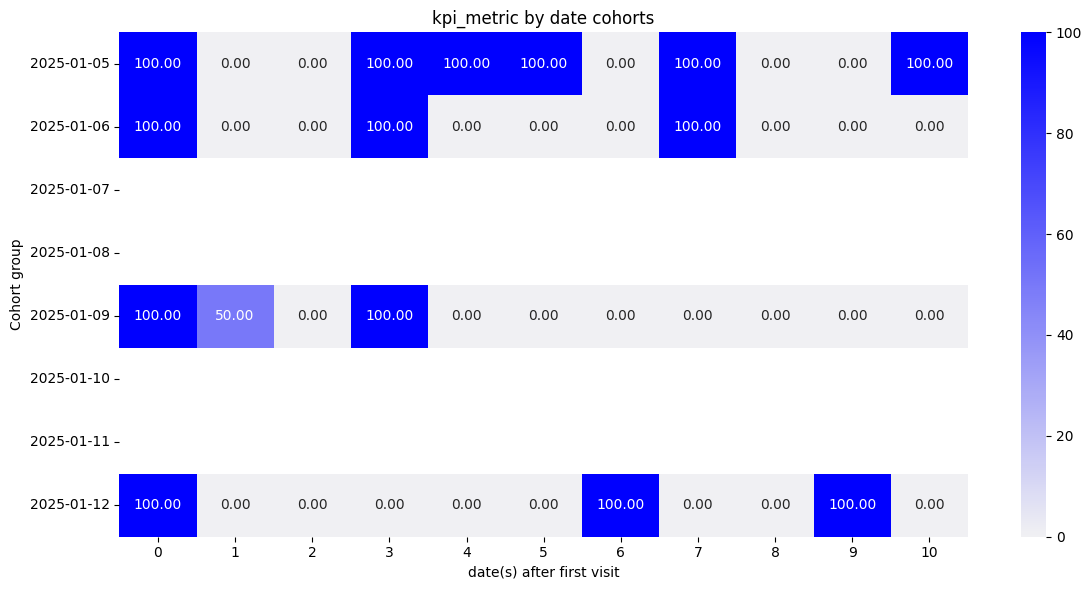

In [180]:
c.plot(min_period='0', max_period='10')

In [66]:
# t[t['cohort_group'] == '2025-01-06']
# t[t['cohort_period'] == 0]
min_time_unit = '2025-01-08'
t.columns = t.columns.astype(str)
t.loc[:, (col for col in t.columns if col >= min_time_unit)]

cohort_time_unit,2025-01-08,2025-01-09,2025-01-10,2025-01-11,2025-01-12,2025-01-13,2025-01-14,2025-01-15,2025-01-16,2025-01-17,...,2025-01-31,2025-02-01,2025-02-02,2025-02-03,2025-02-04,2025-02-05,2025-02-06,2025-02-07,2025-02-08,2025-02-09
cohort_group,,,,,,,,,,,,,,,,,,,,,
2025-01-05,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2025-01-06,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2025-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-09,NaN,2.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2025-01-10,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-11,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-12,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [60]:
%%capture
nc = Cohorts()
nt  = nc.fit(df, cols_schema, kpi_metric, cohort_period='W', represent_by='time_unit', normalize=True)

In [53]:
nt

cohort_time_unit,2025-01-05,2025-01-06,2025-01-07,2025-01-08,2025-01-09,2025-01-10,2025-01-11,2025-01-12,2025-01-13,2025-01-14,...,2025-01-31,2025-02-01,2025-02-02,2025-02-03,2025-02-04,2025-02-05,2025-02-06,2025-02-07,2025-02-08,2025-02-09
cohort_group,,,,,,,,,,,,,,,,,,,,,
2025-01-05,100.0,0.0,0.0,100.0,100.0,100.0,0.0,100.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2025-01-06,NaN,100.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0
2025-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-09,NaN,NaN,NaN,NaN,100.0,50.0,0.0,100.0,0.0,0.0,...,0.0,100.0,50.0,0.0,0.0,50.0,50.0,0.0,0.0,50.0
2025-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


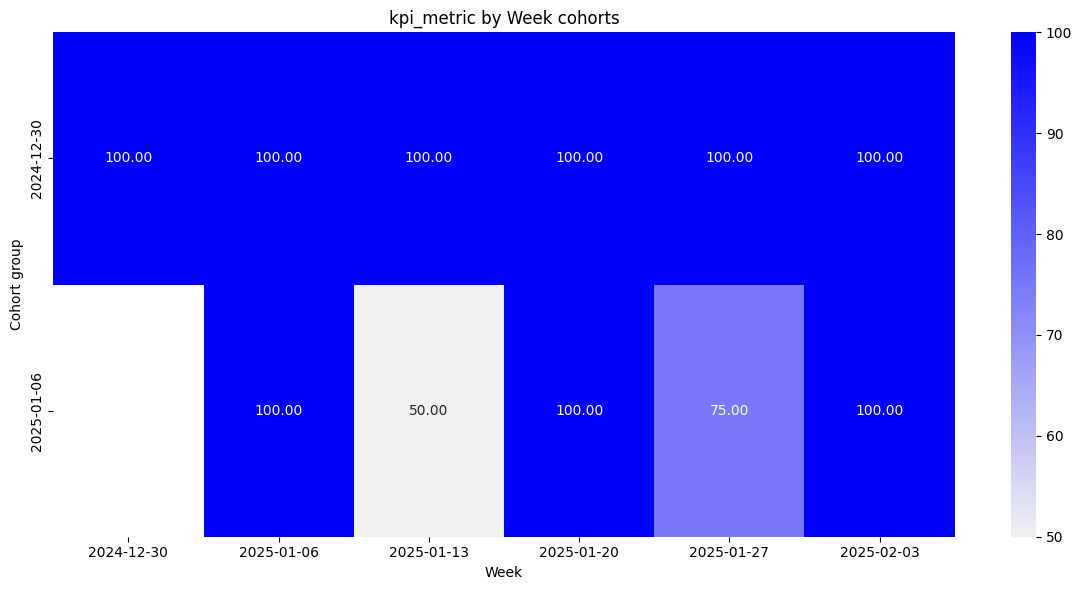

In [61]:
nc.plot(annot=True)